# Tutorial

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation

In [9]:
# standardized environment for discrete action
env = gym.make("RTBEnv-continuous-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=1000,
    n_steps_per_epoch=10,
    update_start_step=10,
    # n_steps=100000,
    # n_steps_per_epoch=1000,
    # update_start_step=1000,
)

2023-03-16 00:40.30 [info     ] Directory is created at d3rlpy_logs/SAC_online_20230316004030
2023-03-16 00:40.30 [debug    ] Fitting action scaler...       action_scler=min_max
2023-03-16 00:40.30 [debug    ] Building model...
2023-03-16 00:40.30 [debug    ] Model has been built.
2023-03-16 00:40.30 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20230316004030/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

  0%|          | 0/1000 [00:00<?, ?it/s]

2023-03-16 00:40.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316004030/model_10.pt
2023-03-16 00:40.30 [info     ] SAC_online_20230316004030: epoch=1 step=10 epoch=1 metrics={'time_inference': 0.0007459878921508789, 'time_environment_step': 0.0003802776336669922, 'time_step': 0.0011490345001220702, 'rollout_return': 19.0, 'evaluation': 15.5} step=10
2023-03-16 00:40.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316004030/model_20.pt
2023-03-16 00:40.30 [info     ] SAC_online_20230316004030: epoch=2 step=20 epoch=2 metrics={'time_inference': 0.00031685829162597656, 'time_environment_step': 0.00029556751251220704, 'time_step': 0.0006329298019409179, 'rollout_return': 34.0, 'evaluation': 17.3} step=20
2023-03-16 00:40.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20230316004030/model_30.pt
2023-03-16 00:40.30 [info     ] SAC_online_20230316004030: epoch=3 step=30 epoch=3 metrics={'time_inference': 0.000391149520

In [13]:
# # save model
# sac.save_model("d3rlpy_logs/sac.pt")

In [14]:
# # reload model
# sac.build_with_env(env_)
# sac.load_model("d3rlpy_logs/sac.pt")

In [15]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [16]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [17]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
# with open("logs/train_dataset_continuous_sac.pkl", "wb") as f:
#     pickle.dump(train_logged_dataset, f)
# with open("logs/test_dataset_continuous_sac.pkl", "wb") as f:
#     pickle.dump(test_logged_dataset, f)

In [19]:
# with open("logs/train_dataset_continuous_sac.pkl", "rb") as f:
#     train_logged_dataset = pickle.load(f)
# with open("logs/test_dataset_continuous_sac.pkl", "rb") as f:
#     test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).

In [20]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL
# transform offline dataset for d3rlpy
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
    discrete_action=False,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [21]:
# Use Conservative Q-Learning policy
cql = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

In [22]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={},
)

2023-03-16 00:42.49 [debug    ] RandomIterator is selected.
2023-03-16 00:42.49 [info     ] Directory is created at d3rlpy_logs/CQL_20230316004249
2023-03-16 00:42.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 00:42.49 [debug    ] Building models...
2023-03-16 00:42.49 [debug    ] Models have been built.
2023-03-16 00:42.49 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230316004249/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-03-16 00:46.15 [info     ] CQL_20230316004249: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00073785982131958, 'time_algorithm_update': 0.0192510009765625, 'temp_loss': 0.13937836506329476, 'temp': 0.8746429017305374, 'alpha_loss': -15.820481412506103, 'alpha': 1.7870967963695525, 'critic_loss': 84.86691558628083, 'actor_loss': -0.8498901910297573, 'time_step': 0.02049645354747772} step=10000
2023-03-16 00:46.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230316004249/model_10000.pt


[(1,
  {'time_sample_batch': 0.00073785982131958,
   'time_algorithm_update': 0.0192510009765625,
   'temp_loss': 0.13937836506329476,
   'temp': 0.8746429017305374,
   'alpha_loss': -15.820481412506103,
   'alpha': 1.7870967963695525,
   'critic_loss': 84.86691558628083,
   'actor_loss': -0.8498901910297573,
   'time_step': 0.02049645354747772})]

In [23]:
# # save model
# cql.save_model("d3rlpy_logs/cql_continuous.pt")

In [24]:
# # reload model
# cql.build_with_env(env)
# cql.load_model("d3rlpy_logs/cql_continuous.pt")

## 2. Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner using (basic) model-based and importance sampling-based estimators.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [25]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation as OPE
# basic estimators
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as DRL

In [26]:
# define evaluation policies (should be deterministic policy)
cql_ = ContinuousEvalHead(
    base_policy=cql,
    name="cql",
)
sac_ = ContinuousEvalHead(
    base_policy=sac, 
    name="sac", 
)
evaluation_policies = [cql_, sac_]

In [27]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        },
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    gamma=0.95,
    sigma=0.1,
    device="cuda:0" if torch.cuda.is_available() else "cpu",
)

In [28]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    require_weight_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-03-16 00:46.16 [debug    ] RoundIterator is selected.
2023-03-16 00:46.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230316004616
2023-03-16 00:46.16 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 00:46.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 00:46.16 [debug    ] Building models...
2023-03-16 00:46.16 [debug    ] Models have been built.
2023-03-16 00:46.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316004616/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.95, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'we

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-03-16 00:46.17 [info     ] FQE_20230316004616: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00010969945362636021, 'time_algorithm_update': 0.0011399095399039132, 'loss': 23.817662264960152, 'time_step': 0.0013015437126159667} step=700
2023-03-16 00:46.17 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316004616/model_700.pt
2023-03-16 00:46.17 [debug    ] RoundIterator is selected.
2023-03-16 00:46.17 [info     ] Directory is created at d3rlpy_logs/FQE_20230316004617
2023-03-16 00:46.17 [debug    ] Fitting scaler...              scaler=min_max
2023-03-16 00:46.17 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-03-16 00:46.17 [debug    ] Building models...
2023-03-16 00:46.17 [debug    ] Models have been built.
2023-03-16 00:46.17 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230316004617/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-03-16 00:46.18 [info     ] FQE_20230316004617: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00011460747037615095, 'time_algorithm_update': 0.00115560701915196, 'loss': 17.104640735217504, 'time_step': 0.0013179380553109306} step=700
2023-03-16 00:46.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230316004617/model_700.pt


[fit MWL model]:   0%|          | 0/2 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[fitting_weight_function]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/2 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
# with open("logs/ope_input_dict_continuous_zoo.pkl", "wb") as f:
#     pickle.dump(input_dict, f)

In [30]:
# with open("logs/ope_input_dict_continuous_zoo.pkl", "rb") as f:
#     input_dict = pickle.load(f)

In [31]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

In [32]:
basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [33]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=all_estimators,
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [34]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(
    input_dict, 
    random_state=random_state,
)
# dictionary of the estimation
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     13.259526               1.000000
 dm             4.860466               0.366564
 tis          175.231405              13.215511
 pdis          14.739618               1.111625
 dr            -4.642209              -0.350104
 sntis         22.618691               1.705845
 snpdis        12.665259               0.955182
 sndr          13.074581               0.986052
 sm_is          0.000000               0.000000
 sm_dr          4.860466               0.366564
 sm_snis        0.000000               0.000000
 sm_sndr        4.860466               0.366564
 sam_is         0.000115               0.000009
 sam_dr         4.858165               0.366391
 sam_snis       3.493908               0.263502
 sam_sndr       7.746783               0.584243
 drl            4.807184               0.362546,
 'sac':            policy_value  relative_policy_value
 on_policy     13.259526               1.000000
 dm             3.769863 

In [35]:
policy_value_dict = ope.estimate_policy_value(
    input_dict=input_dict,
)

In [36]:
# policy_value_dict

{'cql': {'on_policy': 13.259525722031249,
  'dm': 4.860466461706162,
  'tis': 175.2314054802978,
  'pdis': 14.739618120175937,
  'dr': -4.642209047940817,
  'sntis': 22.618690859880452,
  'snpdis': 12.665259360255106,
  'sndr': 13.074580608665164,
  'sm_is': 0.0,
  'sm_dr': 4.860466461706162,
  'sm_snis': 0.0,
  'sm_sndr': 4.860466461706162,
  'sam_is': 0.00011509620219435228,
  'sam_dr': 4.8581649556523345,
  'sam_snis': 3.493907846959563,
  'sam_sndr': 7.746783082708348,
  'drl': 4.8071838723066005},
 'sac': {'on_policy': 13.259525722031249,
  'dm': 3.7698629168987274,
  'tis': 38.44074141665446,
  'pdis': 17.508719288896252,
  'dr': 12.282022370482792,
  'sntis': 13.82727637796905,
  'snpdis': 13.85672201364144,
  'sndr': 13.732130364880495,
  'sm_is': 0.0,
  'sm_dr': 3.7698629168987274,
  'sm_snis': 0.0,
  'sm_sndr': 3.7698629168987274,
  'sam_is': 0.000271935288191729,
  'sam_dr': 3.7701285639778814,
  'sam_snis': 7.936057757800308,
  'sam_sndr': 11.522407933669701,
  'drl': 3.775

In [37]:
from pandas import DataFrame
cql_data=DataFrame()
sac_data=DataFrame()

In [69]:
tmp_cql = DataFrame(policy_value_dict)

In [70]:
tmp_cql

,cql,sac
on_policy,13.259526,13.259526
dm,4.860466,3.769863
tis,175.231405,38.440741
pdis,14.739618,17.508719
dr,-4.642209,12.282022
sntis,22.618691,13.827276
snpdis,12.665259,13.856722
sndr,13.074581,13.732130
sm_is,0.000000,0.000000
sm_dr,4.860466,3.769863


In [77]:
tmp_cql = DataFrame(policy_value_dict)['cql']*2
cql_data = pd.concat([cql_data, tmp_cql], axis=1)
tmp_cql = DataFrame(policy_value_dict)['cql']*4
cql_data = pd.concat([cql_data, tmp_cql], axis=1)
# tmp_sac = DataFrame(policy_value_dict)['sac']
# sac_data = pd.concat([sac_data, tmp_sac], axis=1)

In [78]:
cql_data

,cql,cql,cql,cql,cql,cql,cql,cql,cql,cql
on_policy,13.259526,13.259526,13.259526,14.259526,13.259526,14.259526,23.259526,14.259526,26.519051,53.038103
dm,4.860466,4.860466,4.860466,5.860466,4.860466,5.860466,14.860466,5.860466,9.720933,19.441866
tis,175.231405,175.231405,175.231405,176.231405,175.231405,176.231405,185.231405,176.231405,350.462811,700.925622
pdis,14.739618,14.739618,14.739618,15.739618,14.739618,15.739618,24.739618,15.739618,29.479236,58.958472
dr,-4.642209,-4.642209,-4.642209,-3.642209,-4.642209,-3.642209,5.357791,-3.642209,-9.284418,-18.568836
sntis,22.618691,22.618691,22.618691,23.618691,22.618691,23.618691,32.618691,23.618691,45.237382,90.474763
snpdis,12.665259,12.665259,12.665259,13.665259,12.665259,13.665259,22.665259,13.665259,25.330519,50.661037
sndr,13.074581,13.074581,13.074581,14.074581,13.074581,14.074581,23.074581,14.074581,26.149161,52.298322
sm_is,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,10.000000,1.000000,0.000000,0.000000
sm_dr,4.860466,4.860466,4.860466,5.860466,4.860466,5.860466,14.860466,5.860466,9.720933,19.441866


In [80]:
bias = abs(cql_data.mean(axis=1)-cql_data.mean(axis=1)['on_policy'])
variance = cql_data.var(axis=1)

In [81]:
bias

on_policy      0.000000
dm            11.758683
tis          226.760632
pdis           2.072129
dr            25.062429
sntis         13.102831
snpdis         0.831973
sndr           0.258923
sm_is         18.563336
sm_dr         11.758683
sm_snis       18.563336
sm_sndr       11.758683
sam_is        18.563175
sam_dr        11.761905
sam_snis      13.671865
sam_sndr       7.717840
drl           11.833279
dtype: float64

In [82]:
variance

on_policy      158.338569
dm              25.999320
tis          28466.052811
pdis           195.306805
dr              35.044428
sntis          460.927677
snpdis         144.646131
sndr           154.006610
sm_is            9.566667
sm_dr           25.999320
sm_snis          9.566667
sm_sndr         25.999320
sam_is           9.566534
sam_dr          25.981103
sam_snis        16.922828
sam_sndr        56.626633
drl             25.580114
dtype: float64

In [45]:
# bias.loc['n_trajectory'] = n_trajectory

In [47]:
# n_trajectories=10

In [48]:
# bias_df=DataFrame()
# bias_df[n_trajectories] = bias
# n_trajectories=100
# bias_df[n_trajectories] = bias
# n_trajectories=400
# bias_df[n_trajectories] = bias
# n_trajectories=1600
# bias_df[n_trajectories] = bias
# n_trajectories=6400
# bias_df[n_trajectories] = bias


In [50]:
# bias_df.filter(items=['dm', 'tis'], axis=0)

,10,100,400,1600,6400
dm,8.399059,8.399059,8.399059,8.399059,8.399059
tis,161.971880,161.971880,161.971880,161.971880,161.971880


In [51]:
bias_df_list = []

In [52]:
bias

on_policy      0.000000
dm             8.399059
tis          161.971880
pdis           1.480092
dr            17.901735
sntis          9.359165
snpdis         0.594266
sndr           0.184945
sm_is         13.259526
sm_dr          8.399059
sm_snis       13.259526
sm_sndr        8.399059
sam_is        13.259411
sam_dr         8.401361
sam_snis       9.765618
sam_sndr       5.512743
drl            8.452342
dtype: float64

In [53]:
n_trajectories_list = [100, 200, 400, 800, 1600, 3200, 6400]

In [ ]:
bias_result_df = DataFrame()

In [54]:
for n_trajectories in n_trajectories_list:
    bias = bias + 1
    bias_df = DataFrame(DataFrame(bias).stack())\
    .reset_index(1).rename(columns={"level_1": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)

In [55]:
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)

In [104]:
variance_df_list = []
variance_result_df = DataFrame()

In [105]:
for n_trajectories in n_trajectories_list:
    variance = variance + 1
    variance_df = DataFrame(DataFrame(variance).stack())\
    .reset_index(1).rename(columns={"level_1": "est", 0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)

In [106]:
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)

In [107]:
# bias_result_df
variance_result_df

,index,est,variance,n_trajectories
0,on_policy,0,202.338569,100
1,dm,0,69.999320,100
2,tis,0,28510.052811,100
3,pdis,0,239.306805,100
4,dr,0,79.044428,100
...,...,...,...,...
114,sam_is,0,59.566534,6400
115,sam_dr,0,75.981103,6400
116,sam_snis,0,66.922828,6400
117,sam_sndr,0,106.626633,6400


In [57]:
result_df.query("(index == 'dm' or index == 'tis')")

,index,est,bias,n_trajectories
1,dm,0,9.399059,100
2,tis,0,162.971880,100
18,dm,0,10.399059,200
19,tis,0,163.971880,200
35,dm,0,11.399059,400
36,tis,0,164.971880,400
52,dm,0,12.399059,800
53,tis,0,165.971880,800
69,dm,0,13.399059,1600
70,tis,0,166.971880,1600


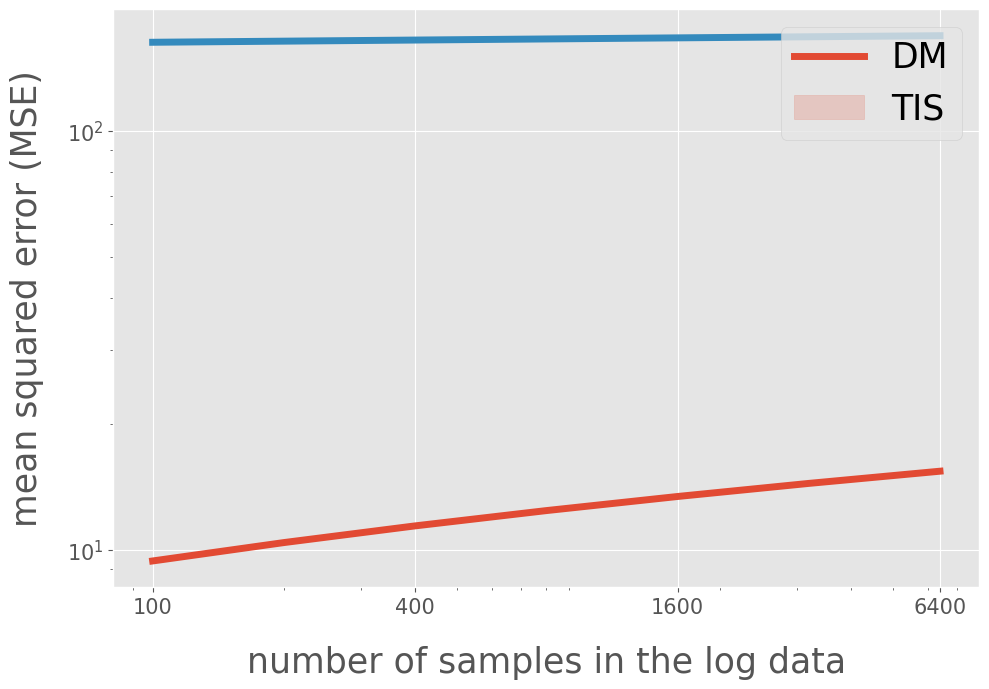

In [58]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=result_df.query("(index == 'dm' or index == 'tis')")
,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

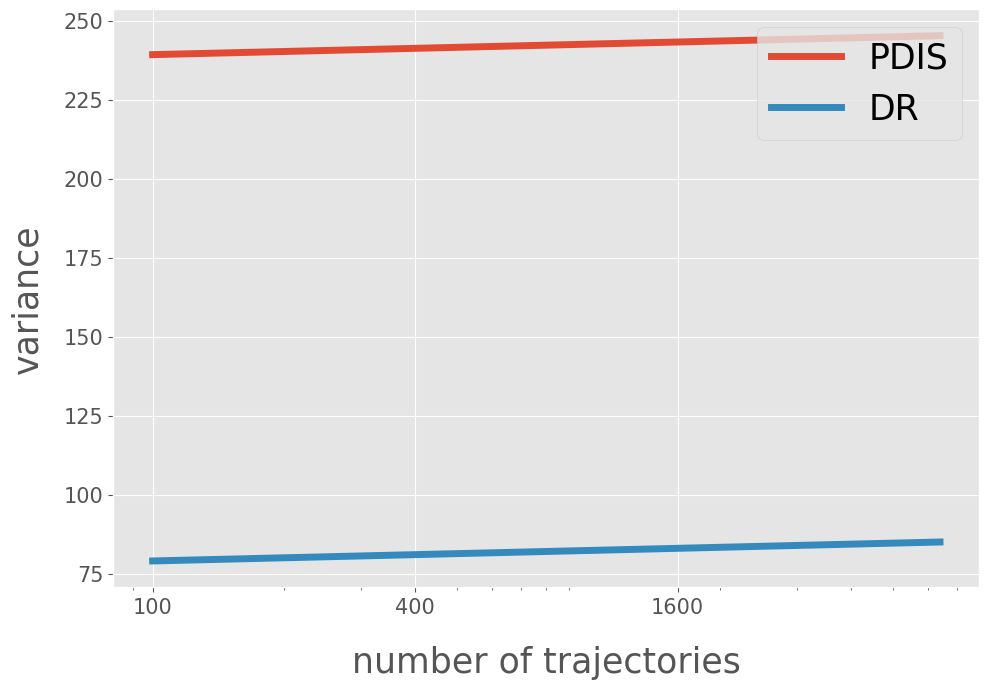

In [108]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [60]:
variance

on_policy    0.0
dm           0.0
tis          0.0
pdis         0.0
dr           0.0
sntis        0.0
snpdis       0.0
sndr         0.0
sm_is        0.0
sm_dr        0.0
sm_snis      0.0
sm_sndr      0.0
sam_is       0.0
sam_dr       0.0
sam_snis     0.0
sam_sndr     0.0
drl          0.0
dtype: float64

In [61]:
policy_value_dict['cql']['on_policy']

13.259525722031249

In [62]:
# # visualize and compare the result
# ope.visualize_off_policy_estimates(
#     input_dict, 
#     compared_estimators=basic_estimators_name,
#     random_state=random_state, 
#     sharey=False,
# )
# # relative policy value to the behavior policy
# # ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

In [63]:
# # visualize and compare the result
# ope.visualize_off_policy_estimates(
#     input_dict, 
#     compared_estimators=state_marginal_estimators_name,
#     random_state=random_state, 
#     sharey=False,
# )

In [64]:
# # visualize and compare the result
# ope.visualize_off_policy_estimates(
#     input_dict, 
#     compared_estimators=state_action_marginal_estimators_name,
#     random_state=random_state, 
#     sharey=False,
# )

In [65]:
# # visualize and compare the result
# ope.visualize_off_policy_estimates(
#     input_dict, 
#     compared_estimators=["dm", "sm_is", "sm_dr", "sam_is", "sam_dr", "drl"],
#     random_state=random_state, 
#     sharey=False,
# )

In [66]:
# ope.visualize_off_policy_estimates(
#     input_dict, 
#     compared_estimators=["dm", "snpdis", "sndr", "sm_snis", "sm_sndr", "sam_snis", "sam_sndr", "drl"],
#     random_state=random_state, 
#     sharey=False,
# )

For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rtb_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_continuous_advanced.ipynb). 

For the examples in the discrete action space, please refer to [examples/quickstart/rtb_synthetic_discrete_zoo.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_zoo.ipynb).

## Reference

- Haanvid Lee, Jongmin Lee, Yunseon Choi, Wonseok Jeon, Byung-Jun Lee, Yung-Kyun Noh, and Kee-Eung Kim. \
"Local Metric Learning for Off-Policy Evaluation in Contextual Bandits with Continuous Actions.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Christina J. Yuan, Yash Chandak, Stephen Giguere, Philip S. Thomas, and Scott Niekum. \
"SOPE: Spectrum of Off-Policy Estimators.", 2021.

- Nathan Kallus and Masatoshi Uehara. \
"Double Reinforcement Learning for Efficient Off-Policy Evaluation in Markov Decision Processes.", 2020.

- Masatoshi Uehara, Jiawei Huang, and Nan Jiang. \
"Minimax Weight and Q-Function Learning for Off-Policy Evaluation.", 2020.

- Mengjiao Yang, Ofir Nachum, Bo Dai, Lihong Li, and Dale Schuurmans. \
"Off-Policy Evaluation via the Regularized Lagrangian.", 2020.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Angela Zhou. \
"Policy Evaluation and Optimization with Continuous Treatments.", 2019.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Qiang Liu, Lihong Li, Ziyang Tang, and Dengyong Zhou. \
"Breaking the Curse of Horizon: Infinite-Horizon Off-Policy Estimation.", 2018

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.